In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import datetime as dt
import pickle

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
random.seed(hash("random seed") % 2**32 - 1)
np.random.seed(hash("numpy seed") % 2**32 - 1)
tf.random.set_seed(hash("tensorflow seed") % 2**32 - 1)

In [13]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [3]:
def ts_offset_split(dataframe, steps, lookback, horizon, batch_size, scaler='standard'):
    start = 0
    end = 168
    offset = 24
    training = []
    validation = []

    for i in range(int((365+366)/8)):

        train = dataframe.iloc[start:end]
        val = dataframe.iloc[end:end+offset]
        training.append(train)
        validation.append(val)

        start += 192
        end += 192
    
    # Decide Splits for sets
    train = pd.concat(training)

    val = pd.concat(validation)
    train = train.append(dataframe[(dataframe.index.date > val.index.max()) & (dataframe.index.date < dt.date(2021,1,1))])

    test = dataframe[dataframe.index.date >= dt.date(2021,1,1)]
    
    tmpdf = pd.concat([train,val,test])

    # Scaler
    if scaler == 'standard':
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif scaler == 'minmax':
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
    else:
        print("Please specify one of 'standard' or 'minmax' to scaler parameter.")
    
    # Training
    start = lookback + horizon
    end = start + train.shape[0]

    X_train = train.values
    y_train = tmpdf.iloc[start:end][['Value']]

    X_train = X_scaler.fit_transform(X_train)
    y_train = y_scaler.fit_transform(y_train)

    # Validation
    x_end = len(val) - lookback - horizon
    y_val_start = train.shape[0] + lookback + horizon

    X_val = val.iloc[:x_end]
    y_val = tmpdf.iloc[y_val_start:y_val_start+x_end][['Value']]

    X_val = X_scaler.transform(X_val)
    y_val = y_scaler.transform(y_val)

    # Test
    x_end = len(test) - lookback - horizon
    y_test_start = (train.shape[0] + val.shape[0]) + lookback + horizon

    X_test = test.iloc[:x_end]
    y_test = tmpdf.iloc[y_test_start:y_test_start+x_end][['Value']]

    X_test = X_scaler.transform(X_test)
    y_test = y_scaler.transform(y_test)

    # Batch Sequence Generators
    sequence_length = int(lookback/steps)

    dataset_train = timeseries_dataset_from_array(
        X_train, y_train,
        sequence_length=sequence_length,
        sampling_rate=steps,
        batch_size=batch_size,
        shuffle=True
    )

    dataset_val = timeseries_dataset_from_array(
        X_val, y_val,
        sequence_length=sequence_length,
        sampling_rate=steps,
        batch_size=batch_size,
        shuffle=True
    )    

    dataset_test = timeseries_dataset_from_array(
        X_test, y_test,
        sequence_length=sequence_length,
        sampling_rate=steps,
        batch_size=batch_size,
        shuffle=False
    )    

    return dataset_train, dataset_val, dataset_test

In [101]:
def plot_training(history, title, filename):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(loss))
    
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.title(title, fontsize=24)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'/content/drive/MyDrive/Thesis/{filename}.png', bbox_inches='tight')
    plt.show()

In [5]:
kld = pd.read_csv('/content/drive/MyDrive/Thesis/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
kld = kld[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]
stb = pd.read_csv('/content/drive/MyDrive/Thesis/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = stb[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]

In [6]:
# Processing Parameters
steps = 1 # timesteps: 1 hour
num_features = 9

lookback = 744 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 224
epochs = 100
lr = 0.04

In [7]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = ts_offset_split(kld, steps=steps, lookback=lookback,
                                              horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = ts_offset_split(stb, steps=steps, lookback=lookback,
                                              horizon=horizon, batch_size=batch_size, scaler='standard')

# Middelfart

In [8]:
# GRU Benchmark: Middelfart
GRU_base_stb = Sequential()
GRU_base_stb.add(Input(shape=(lookback, num_features)))

GRU_base_stb.add(GRU(96, return_sequences=False, activation='tanh'))
GRU_base_stb.add(Dropout(0.2))

GRU_base_stb.add(Dense(1))

GRU_base_stb.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

GRU_base_stb.summary()



estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "/content/drive/MyDrive/Thesis/GRU_benchmark_stb.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


history_stb_gru = GRU_base_stb.fit(
    stb_train,
    epochs=epochs,
    validation_data=stb_val,
    callbacks=[estp, ckpt, reduce_lr]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 96)                30816     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 30,913
Trainable params: 30,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
66/66 [==============================] - 38s 81ms/step - loss: 0.5887 - mae: 0.5792 - val_loss: 0.4019 - val_mae: 0.4465

Epoch 00001: val_loss improved from inf to 0.40194, saving model to /content/drive/MyDrive/Thesis/GRU_benchmark_stb.h5
Epoch 2/100
66/66 [==============================] - 5s 72ms/step - loss: 0.3465 - mae: 0.4274 - val_loss: 0.3906 - val_mae: 0.44

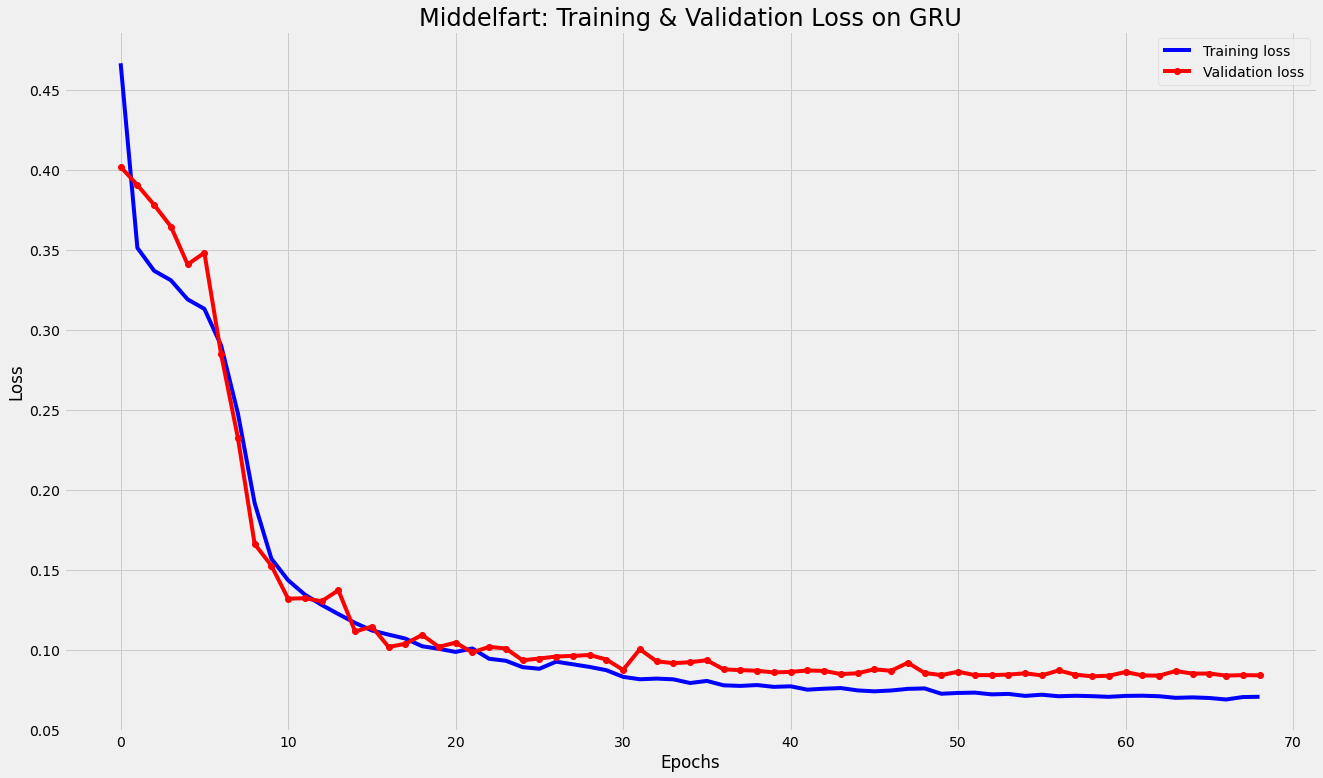

In [102]:
plot_training(history_stb_gru, 'Middelfart: Training & Validation Loss on GRU', 'history_stb_gru')

In [12]:
stb_eval_gru = GRU_base_stb.evaluate(stb_test)

7/7 [==============================] - 0s 61ms/step - loss: 0.1306 - mae: 0.2721


In [16]:
stb_std = 18.33954707
print(f'Inverse Scaled MAE: {round(stb_eval_gru[1] * stb_std, 2)}')

Inverse Scaled MAE: 4.99


In [17]:
# LSTM Benchmark
LSTM_base_stb = Sequential()

LSTM_base_stb.add(Input(shape=(lookback, num_features)))

LSTM_base_stb.add(LSTM(96, return_sequences=False, activation='tanh'))
LSTM_base_stb.add(Dropout(0.2))

LSTM_base_stb.add(Dense(1))

LSTM_base_stb.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

LSTM_base_stb.summary()


estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "/content/drive/MyDrive/Thesis/LSTM_benchmark_stb.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


history_stb_lstm = LSTM_base_stb.fit(
    stb_train,
    epochs=epochs,
    validation_data=stb_val,
    callbacks=[estp, ckpt, reduce_lr]
)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96)                40704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
66/66 [==============================] - 7s 84ms/step - loss: 0.5953 - mae: 0.5937 - val_loss: 0.4932 - val_mae: 0.5033

Epoch 00001: val_loss improved from inf to 0.49316, saving model to /content/drive/MyDrive/Thesis/LSTM_benchmark_stb.h5
Epoch 2/100
66/66 [==============================] - 5s 78ms/step - loss: 0.3583 - mae: 0.4413 - val_loss: 0.3009 - val_mae: 0.

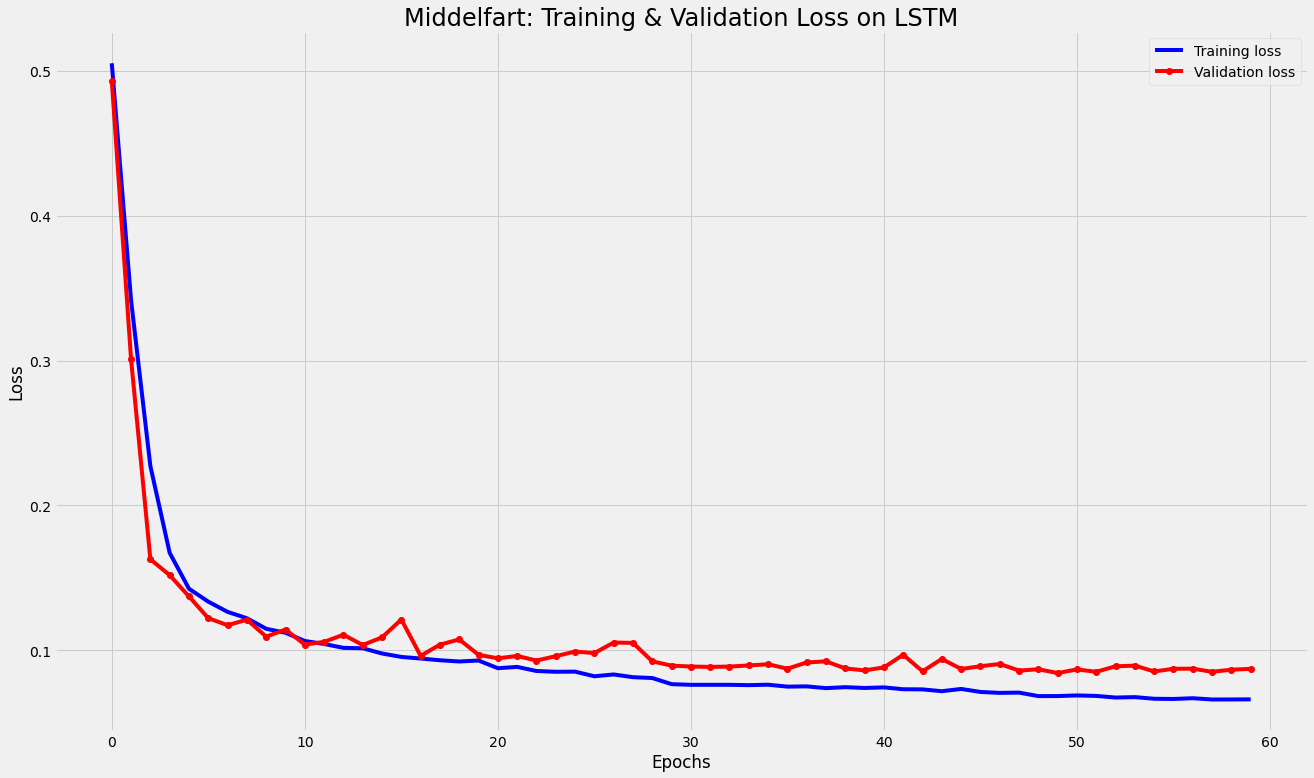

In [103]:
plot_training(history_stb_lstm, 'Middelfart: Training & Validation Loss on LSTM', 'history_stb_lstm')

In [19]:
stb_eval_lstm = LSTM_base_stb.evaluate(stb_test)

7/7 [==============================] - 1s 68ms/step - loss: 0.1473 - mae: 0.2882


In [20]:
stb_std = 18.33954707
print(f'Inverse Scaled MAE: {round(stb_eval_lstm[1] * stb_std, 2)}')

Inverse Scaled MAE: 5.28


# Kolding

In [21]:
# GRU Benchmark
GRU_base_kld = Sequential()
GRU_base_kld.add(Input(shape=(lookback, num_features)))

GRU_base_kld.add(GRU(96, return_sequences=False, activation='tanh'))
GRU_base_kld.add(Dropout(0.2))

GRU_base_kld.add(Dense(1))

GRU_base_kld.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

GRU_base_kld.summary()


# Callbacks
estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, verbose=1)

ckpt_path = "/content/drive/MyDrive/Thesis/GRU_benchmark_kld.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


history_kld_gru = GRU_base_kld.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt, reduce_lr]
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 96)                30816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 97        
Total params: 30,913
Trainable params: 30,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
66/66 [==============================] - 7s 79ms/step - loss: 0.5624 - mae: 0.5642 - val_loss: 0.4184 - val_mae: 0.4458

Epoch 00001: val_loss improved from inf to 0.41836, saving model to /content/drive/MyDrive/Thesis/GRU_benchmark_kld.h5
Epoch 2/100
66/66 [==============================] - 5s 73ms/step - loss: 0.3514 - mae: 0.4265 - val_loss: 0.3876 - val_mae: 0.4

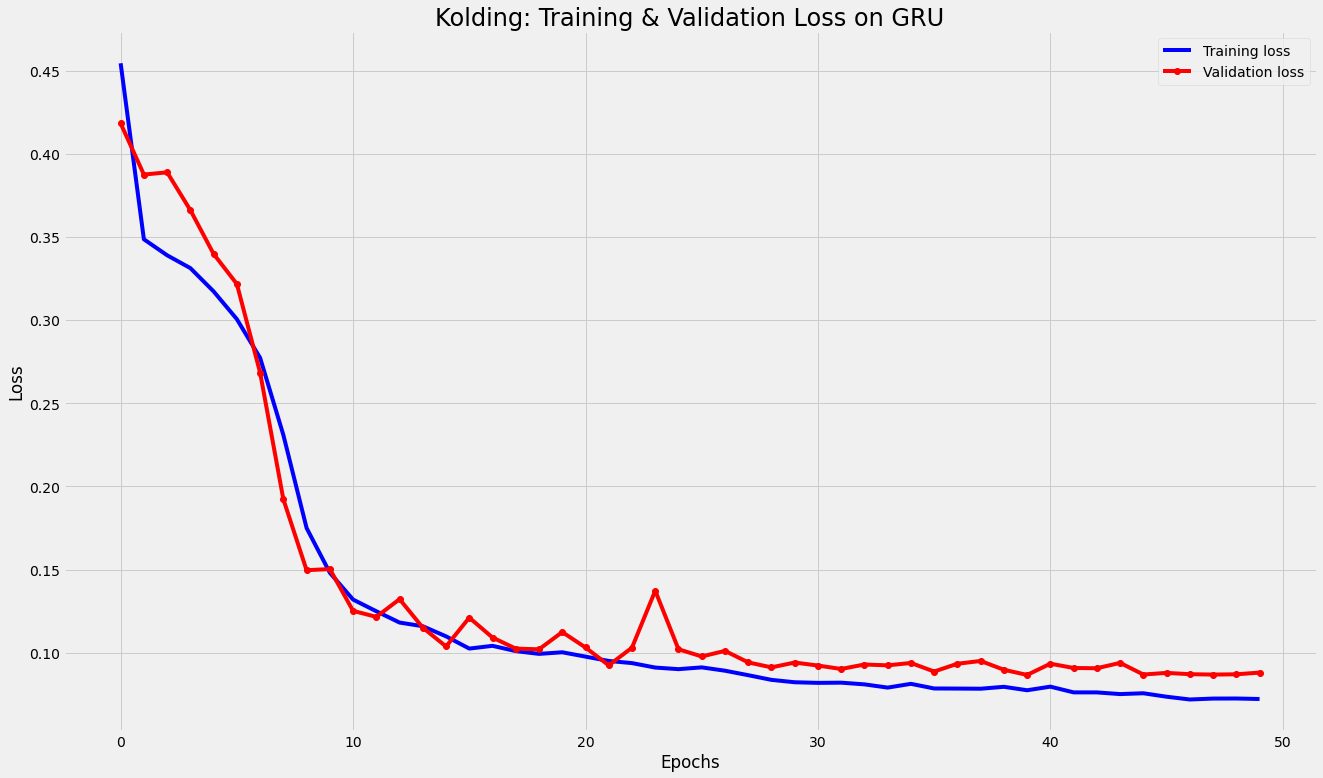

In [104]:
plot_training(history_kld_gru, 'Kolding: Training & Validation Loss on GRU', 'history_kld_gru')

In [23]:
kld_eval_gru = GRU_base_kld.evaluate(kld_test)

7/7 [==============================] - 0s 49ms/step - loss: 0.1428 - mae: 0.2788


In [24]:
kld_std = 31.31291841
print(f'Inverse Scaled MAE: {round(kld_eval_gru[1] * kld_std, 2)}')

Inverse Scaled MAE: 8.73


In [25]:
# LSTM Benchmark
LSTM_base_kld = Sequential()
LSTM_base_kld.add(Input(shape=(lookback, num_features)))

LSTM_base_kld.add(LSTM(96, return_sequences=False, activation='tanh'))
LSTM_base_kld.add(Dropout(0.2))

LSTM_base_kld.add(Dense(1))

LSTM_base_kld.compile(optimizer=SGD(momentum=0.9, learning_rate=lr), loss="mse", metrics=['mae'])

LSTM_base_kld.summary()


# Callbacks
estp = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, verbose=1)

ckpt_path = "/content/drive/MyDrive/Thesis/LSTM_benchmark_kld.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


history_kld_lstm = LSTM_base_kld.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 96)                40704     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 97        
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
66/66 [==============================] - 7s 85ms/step - loss: 0.6659 - mae: 0.6239 - val_loss: 0.4723 - val_mae: 0.5271

Epoch 00001: val_loss improved from inf to 0.47230, saving model to /content/drive/MyDrive/Thesis/LSTM_benchmark_kld.h5
Epoch 2/100
66/66 [==============================] - 5s 79ms/step - loss: 0.3662 - mae: 0.4454 - val_loss: 0.3293 - val_mae: 0.

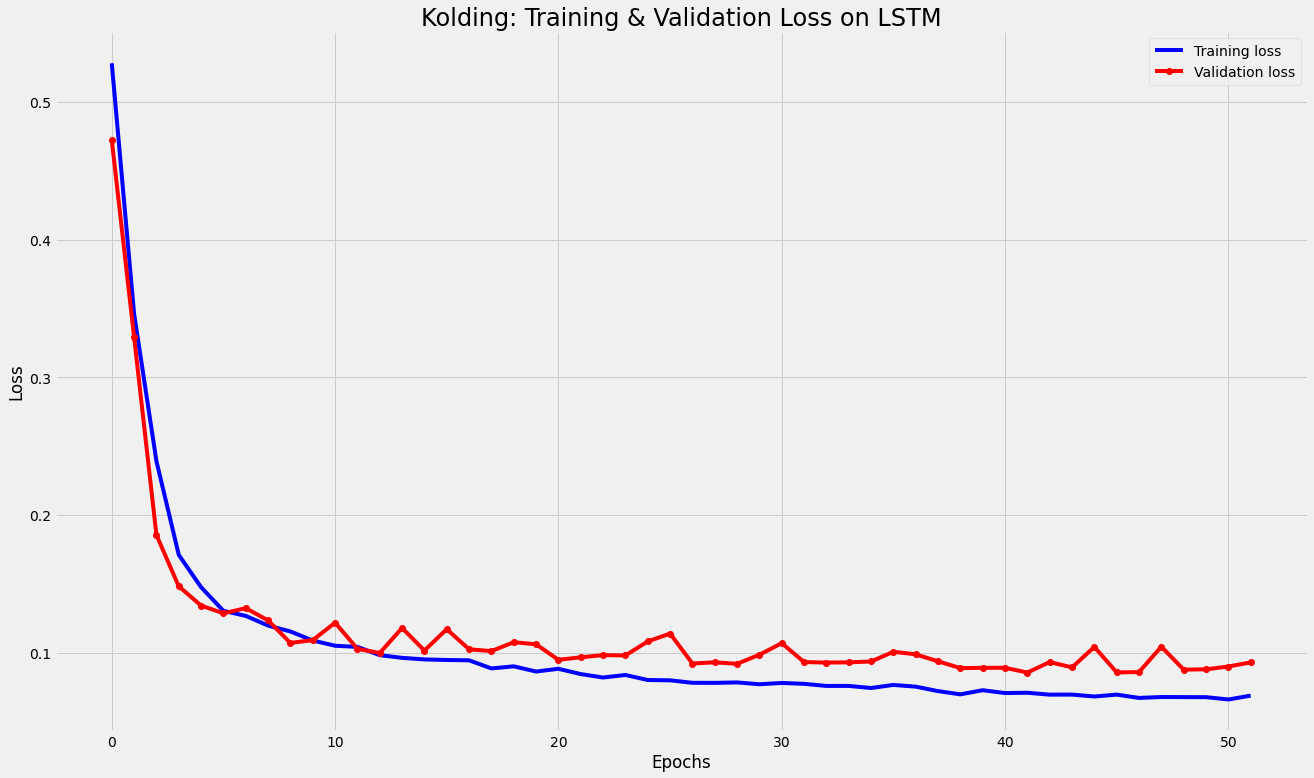

In [105]:
plot_training(history_kld_lstm, 'Kolding: Training & Validation Loss on LSTM', 'history_kld_lstm')

In [26]:
kld_eval_lstm = LSTM_base_kld.evaluate(kld_test)

7/7 [==============================] - 1s 64ms/step - loss: 0.1606 - mae: 0.2891


In [29]:
kld_std = 31.31291841
kld_mean = 87.50684772
print(f'Inverse Scaled MAE: {round(kld_eval_lstm[1] * kld_std, 2)}')

Inverse Scaled MAE: 9.05


In [43]:
stb_mean = 52.17963965

In [44]:
def predict_kolding(model):
    pred = model.predict(kld_test)
    inverse_scaled_pred = (pred * kld_std) + kld_mean

    y_true = pd.read_csv('/content/drive/MyDrive/Thesis/y_true_kolding.csv', index_col='Datetime', parse_dates=['Datetime'])

    pred_df = y_true.copy()
    pred_df.rename(columns={'Value':'True'}, inplace=True)
    pred_df['Pred'] = inverse_scaled_pred

    return pred_df

def predict_middelfart(model):
    pred = model.predict(stb_test)
    inverse_scaled_pred = (pred * stb_std) + stb_mean

    y_true = pd.read_csv('/content/drive/MyDrive/Thesis/y_true_strib.csv', index_col='Datetime', parse_dates=['Datetime'])

    pred_df = y_true.copy()
    pred_df.rename(columns={'Value':'True'}, inplace=True)
    pred_df['Pred'] = inverse_scaled_pred

    return pred_df


def metrics(true, pred):
    print(f'MSE: {np.mean(mean_squared_error(true, pred))}')
    print(f'MAE: {np.mean(mean_absolute_error(true, pred))}')
    print(f'MAPE: {np.mean(mean_absolute_percentage_error(true, pred))}')

In [41]:
# LSTM Kolding
kld_lstm_pred = predict_kolding(LSTM_base_kld)
metrics(kld_lstm_pred['True'].values, kld_lstm_pred['Pred'].values)

MSE: 141.501708984375
MAE: 8.733819961547852
MAPE: 8.137969970703125


In [42]:
# GRU Kolding
kld_gru_pred = predict_kolding(GRU_base_kld)
metrics(kld_gru_pred['True'].values, kld_gru_pred['Pred'].values)

MSE: 133.40220642089844
MAE: 8.549830436706543
MAPE: 8.171585083007812


In [45]:
# LSTM Middelfart
stb_lstm_pred = predict_middelfart(LSTM_base_stb)
metrics(stb_lstm_pred['True'].values, stb_lstm_pred['Pred'].values)

MSE: 106.52617645263672
MAE: 7.845577239990234
MAPE: 10.936578750610352


In [46]:
# GRU Middelfart
stb_gru_pred = predict_middelfart(GRU_base_stb)
metrics(stb_gru_pred['True'].values, stb_gru_pred['Pred'].values)

MSE: 96.00928497314453
MAE: 7.489893913269043
MAPE: 10.538400650024414


# GRU Kolding

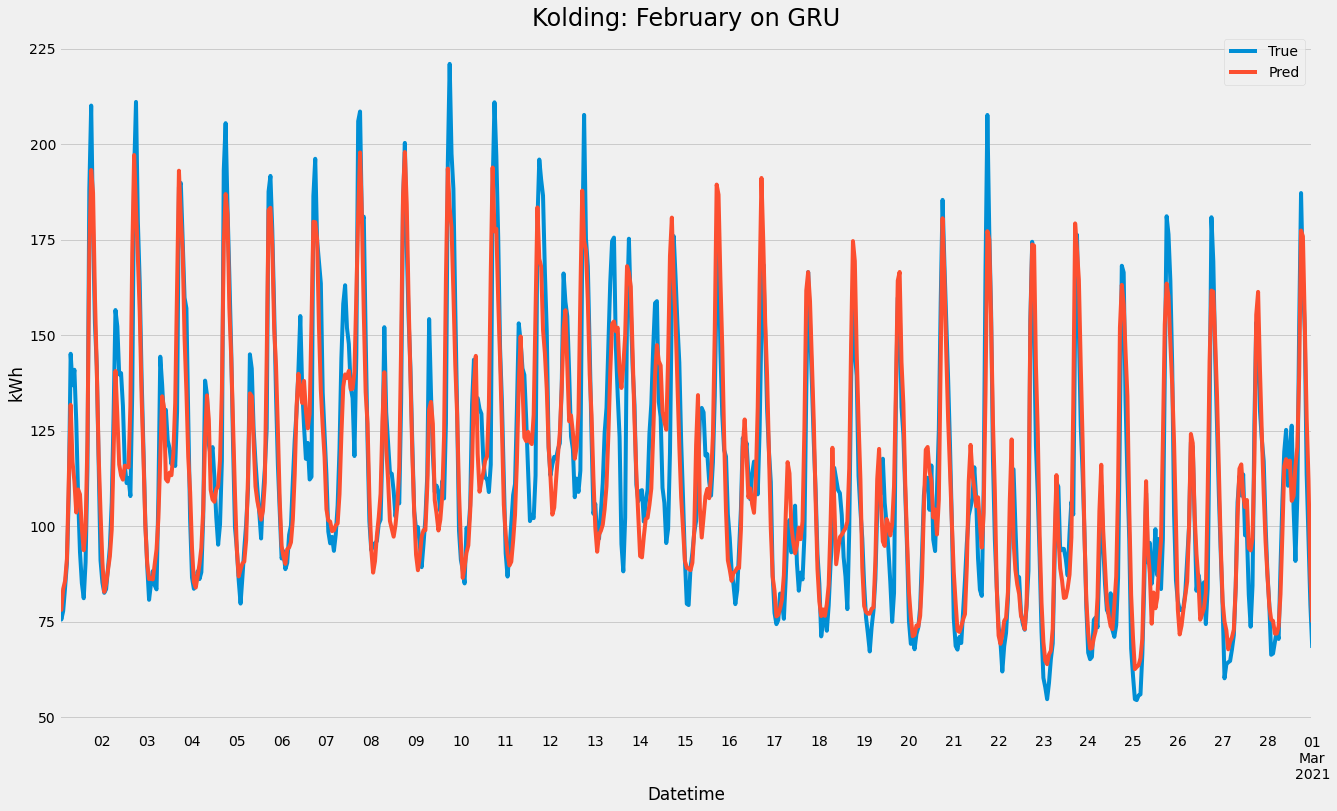

In [108]:
ax = kld_gru_pred.loc[dt.date(2021, 2, 1):dt.date(2021, 3, 1)].plot()
ax.set_title('Kolding: February on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_february_kolding.png', bbox_inches='tight')
plt.show()

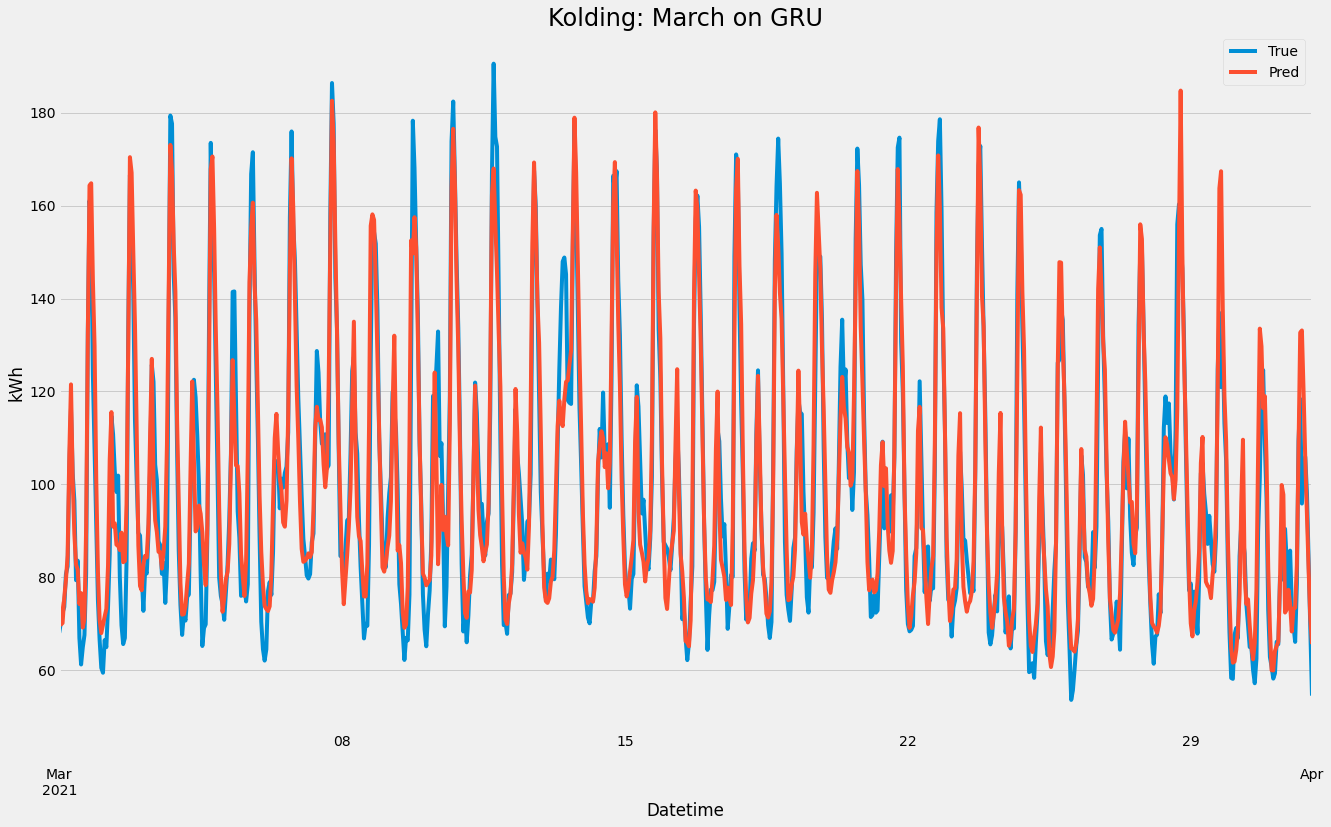

In [107]:
ax = kld_gru_pred.loc[dt.date(2021, 3, 1):dt.date(2021, 4, 1)].plot()
ax.set_title('Kolding: March on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_march_kolding.png', bbox_inches='tight')
plt.show()

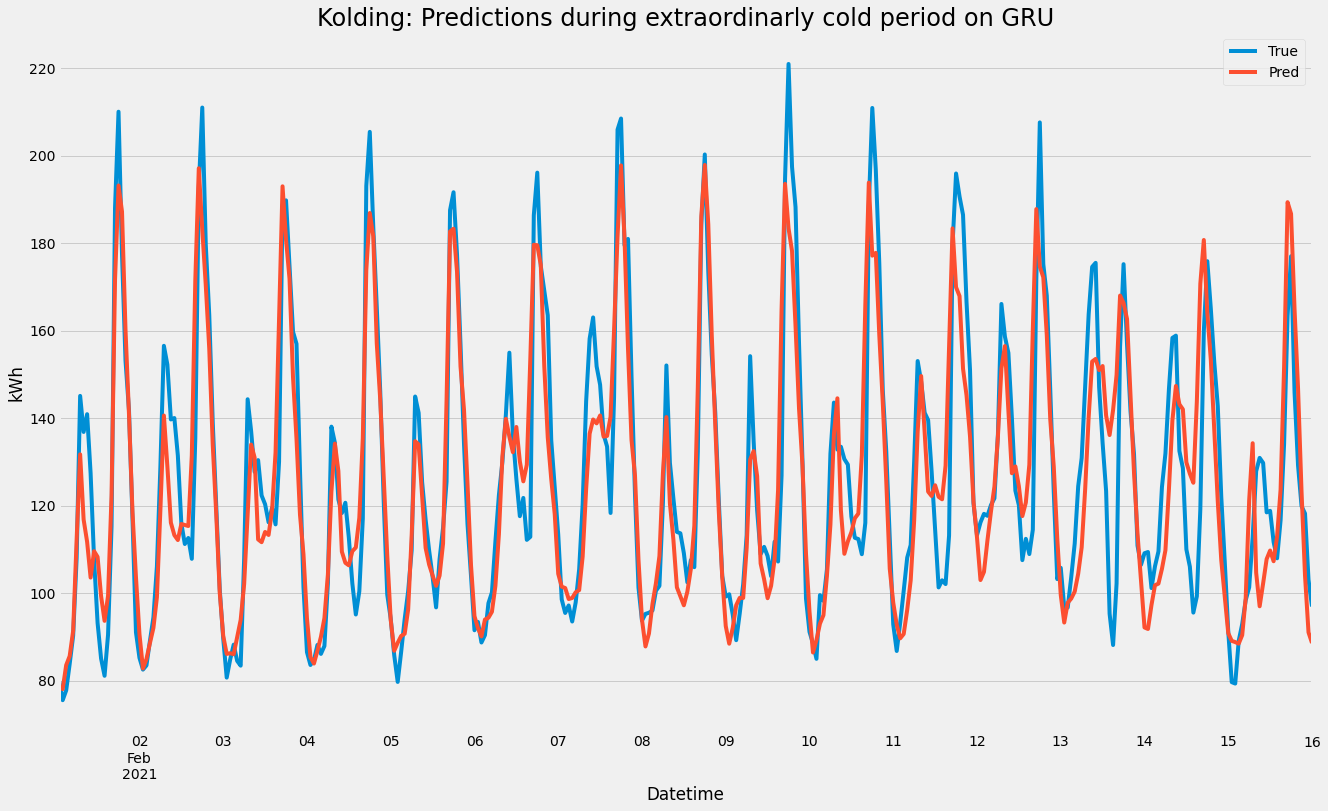

In [94]:
ax = kld_gru_pred.loc[dt.date(2021, 2, 1):dt.date(2021, 2, 16)].plot()
ax.set_title('Kolding: Predictions during extraordinarly cold period on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_cold_period_kolding.png', bbox_inches='tight')
plt.show()

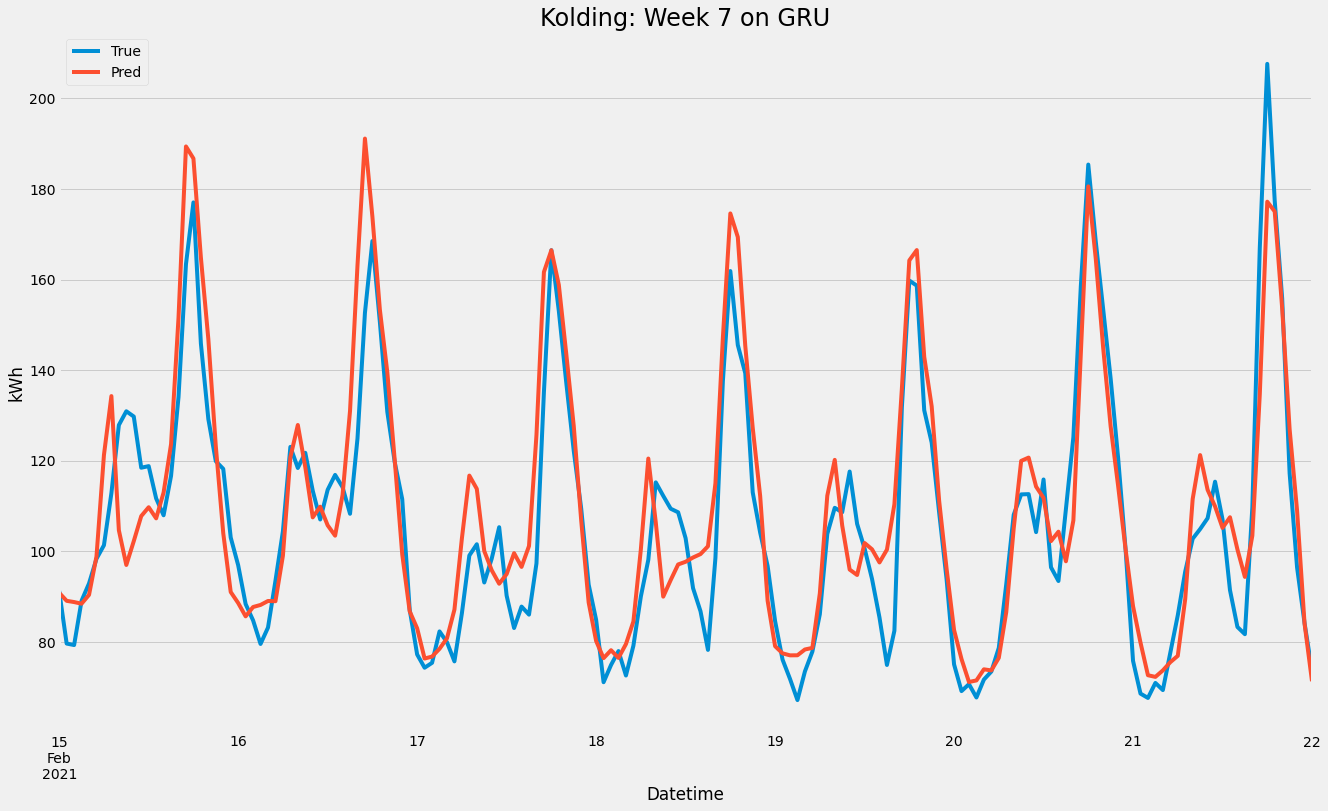

In [91]:
ax = kld_gru_pred.loc[dt.date(2021, 2, 15):dt.date(2021, 2, 22)].plot()
ax.set_title('Kolding: Week 7 on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_week7_kolding.png', bbox_inches='tight')
plt.show()

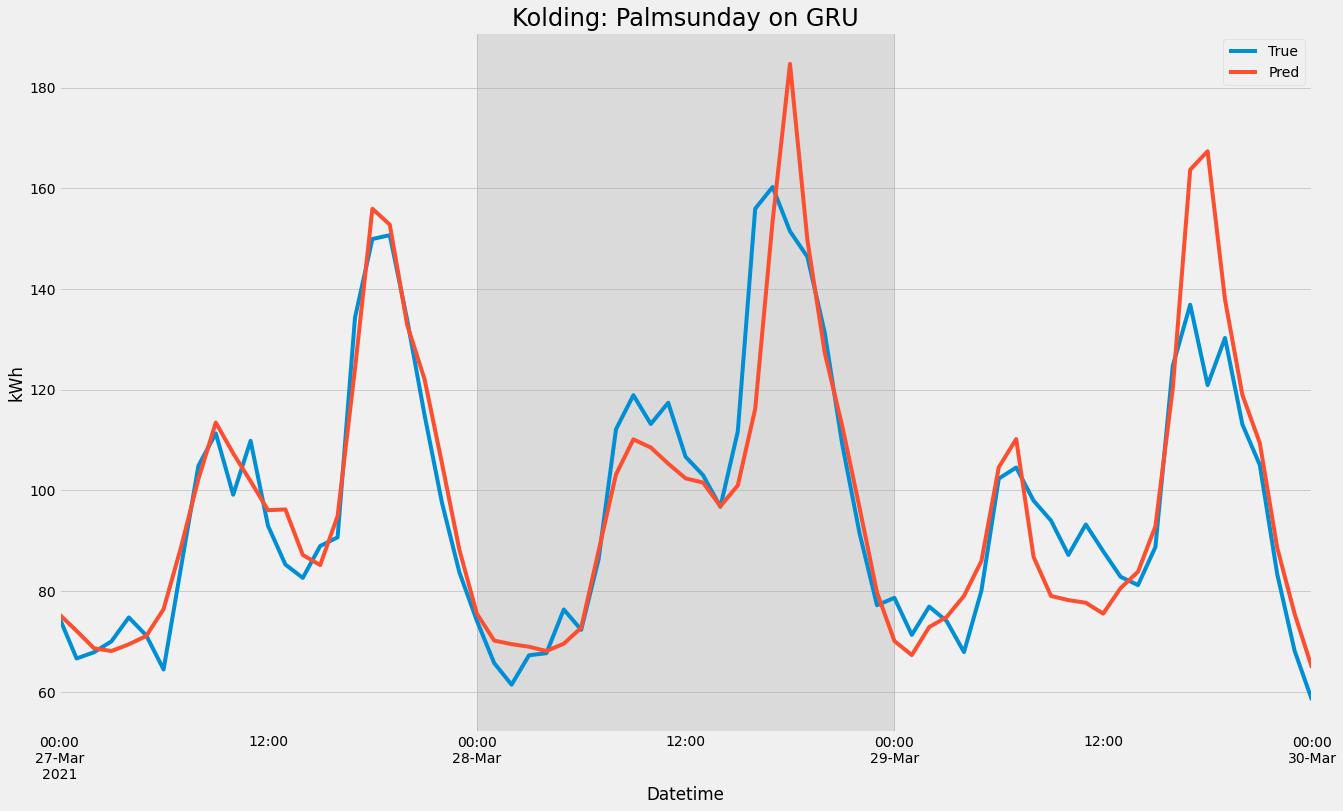

In [92]:
ax = kld_gru_pred.loc[dt.date(2021, 3, 27):dt.date(2021, 3, 30)].plot()
ax.set_title('Kolding: Palmsunday on GRU', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 3, 28), dt.date(2021, 3, 29), color='darkgrey', alpha=.3)
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_palmsunday_kolding.png', bbox_inches='tight')
plt.show()

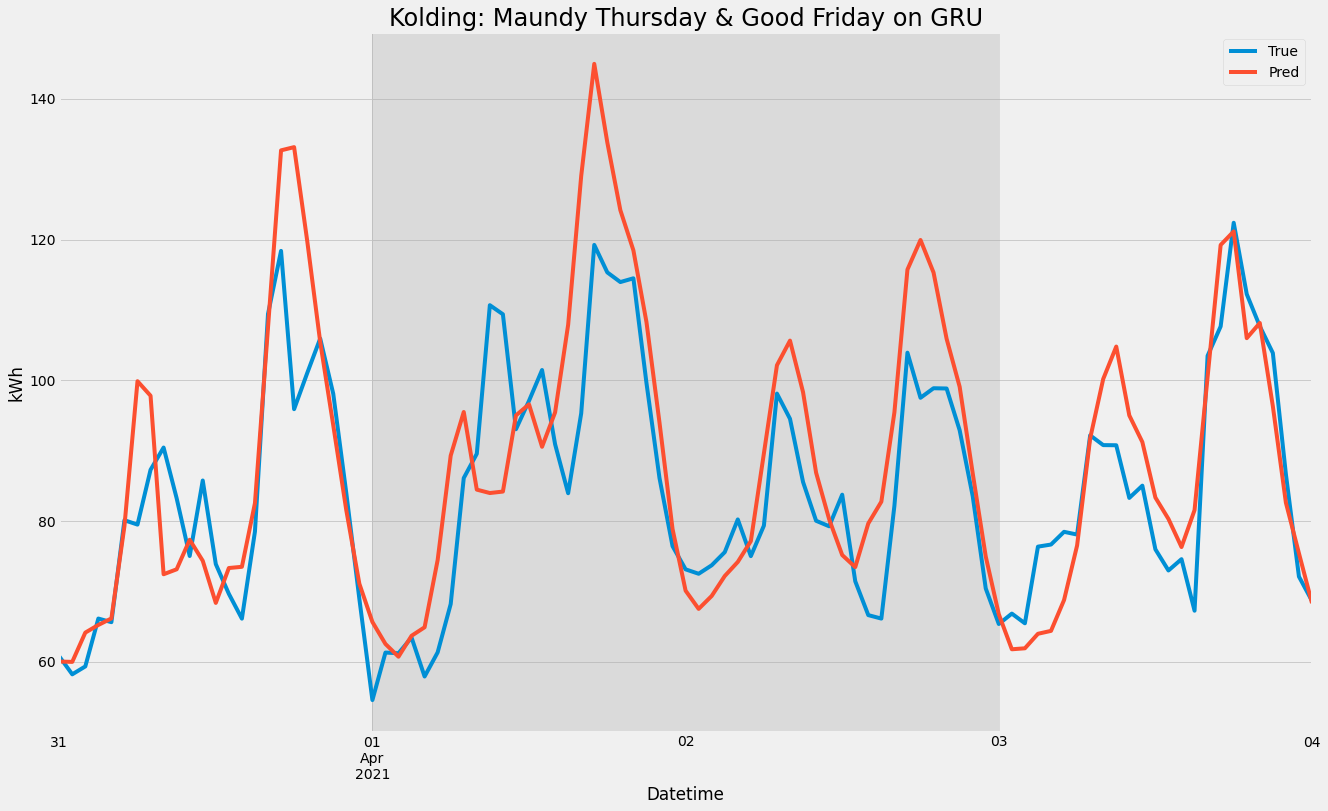

In [93]:
ax = kld_gru_pred.loc[dt.date(2021, 3, 31):dt.date(2021, 4, 4)].plot()
ax.set_title('Kolding: Maundy Thursday & Good Friday on GRU', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 4, 1), dt.date(2021, 4, 3), color='darkgrey', alpha=.3)
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_goodfriday_kolding.png', bbox_inches='tight')
plt.show()

In [50]:
def get_weekday(weekday, pred_df):
    day_df = pred_df[pred_df.index.weekday == weekday]
    return day_df

mon = get_weekday(0, kld_gru_pred)
tue = get_weekday(1, kld_gru_pred)
wed = get_weekday(2, kld_gru_pred)
thu = get_weekday(3, kld_gru_pred)
fri = get_weekday(4, kld_gru_pred)
sat = get_weekday(5, kld_gru_pred)
sun = get_weekday(6, kld_gru_pred)

metrics(mon['True'].values, mon['Pred'].values)

MSE: 118.96503448486328
MAE: 8.067849159240723
MAPE: 7.648085117340088


In [51]:
metrics(tue['True'].values, tue['Pred'].values)

MSE: 142.228271484375
MAE: 8.752082824707031
MAPE: 8.485987663269043


In [52]:
metrics(wed['True'].values, wed['Pred'].values)

MSE: 141.5778045654297
MAE: 8.760672569274902
MAPE: 8.619162559509277


In [53]:
metrics(thu['True'].values, thu['Pred'].values)

MSE: 153.75588989257812
MAE: 9.703807830810547
MAPE: 9.484097480773926


In [54]:
metrics(fri['True'].values, fri['Pred'].values)

MSE: 98.03032684326172
MAE: 7.350676536560059
MAPE: 7.288624286651611


In [55]:
metrics(sat['True'].values, sat['Pred'].values)

MSE: 132.045166015625
MAE: 8.311077117919922
MAPE: 7.805629730224609


In [56]:
metrics(sun['True'].values, sun['Pred'].values)

MSE: 148.78392028808594
MAE: 8.942190170288086
MAPE: 7.830803871154785


In [57]:
kld_gru_day_mae = [8.07, 8.75, 8.76, 9.7, 7.35, 8.31, 8.94]

In [59]:
mon = get_weekday(0, kld_lstm_pred)
tue = get_weekday(1, kld_lstm_pred)
wed = get_weekday(2, kld_lstm_pred)
thu = get_weekday(3, kld_lstm_pred)
fri = get_weekday(4, kld_lstm_pred)
sat = get_weekday(5, kld_lstm_pred)
sun = get_weekday(6, kld_lstm_pred)

metrics(mon['True'].values, mon['Pred'].values)
metrics(tue['True'].values, tue['Pred'].values)
metrics(wed['True'].values, wed['Pred'].values)
metrics(thu['True'].values, thu['Pred'].values)
metrics(fri['True'].values, fri['Pred'].values)
metrics(sat['True'].values, sat['Pred'].values)
metrics(sun['True'].values, sun['Pred'].values)

MSE: 98.90120697021484
MAE: 7.310910224914551
MAPE: 6.879075527191162
MSE: 142.6447296142578
MAE: 8.971477508544922
MAPE: 8.775290489196777
MSE: 142.5172576904297
MAE: 8.994331359863281
MAPE: 8.66506290435791
MSE: 167.51991271972656
MAE: 9.869355201721191
MAPE: 9.24720287322998
MSE: 123.91297912597656
MAE: 7.91480827331543
MAPE: 7.527588844299316
MSE: 164.16360473632812
MAE: 9.187582969665527
MAPE: 8.234749794006348
MSE: 151.7458038330078
MAE: 8.89930248260498
MAPE: 7.570582389831543


In [60]:
kld_lstm_day_mae = [7.31, 8.97, 8.99, 9.87, 7.91, 9.19, 8.9]

In [61]:
mon = get_weekday(0, stb_gru_pred)
tue = get_weekday(1, stb_gru_pred)
wed = get_weekday(2, stb_gru_pred)
thu = get_weekday(3, stb_gru_pred)
fri = get_weekday(4, stb_gru_pred)
sat = get_weekday(5, stb_gru_pred)
sun = get_weekday(6, stb_gru_pred)

metrics(mon['True'].values, mon['Pred'].values)
metrics(tue['True'].values, tue['Pred'].values)
metrics(wed['True'].values, wed['Pred'].values)
metrics(thu['True'].values, thu['Pred'].values)
metrics(fri['True'].values, fri['Pred'].values)
metrics(sat['True'].values, sat['Pred'].values)
metrics(sun['True'].values, sun['Pred'].values)

MSE: 124.66088104248047
MAE: 8.321560859680176
MAPE: 11.520492553710938
MSE: 80.80033111572266
MAE: 6.860452175140381
MAPE: 10.227381706237793
MSE: 106.59310913085938
MAE: 7.855391502380371
MAPE: 11.181645393371582
MSE: 87.94583129882812
MAE: 7.296219348907471
MAPE: 10.521201133728027
MSE: 96.12416076660156
MAE: 7.309476375579834
MAPE: 10.24870491027832
MSE: 79.26362609863281
MAE: 7.138171195983887
MAPE: 9.883397102355957
MSE: 96.90509796142578
MAE: 7.671134948730469
MAPE: 10.149083137512207


In [62]:
stb_gru_day_mae = [8.32, 6.86, 7.86, 7.3, 7.31, 7.14, 7.67]

In [63]:
mon = get_weekday(0, stb_lstm_pred)
tue = get_weekday(1, stb_lstm_pred)
wed = get_weekday(2, stb_lstm_pred)
thu = get_weekday(3, stb_lstm_pred)
fri = get_weekday(4, stb_lstm_pred)
sat = get_weekday(5, stb_lstm_pred)
sun = get_weekday(6, stb_lstm_pred)

metrics(mon['True'].values, mon['Pred'].values)
metrics(tue['True'].values, tue['Pred'].values)
metrics(wed['True'].values, wed['Pred'].values)
metrics(thu['True'].values, thu['Pred'].values)
metrics(fri['True'].values, fri['Pred'].values)
metrics(sat['True'].values, sat['Pred'].values)
metrics(sun['True'].values, sun['Pred'].values)

MSE: 131.23585510253906
MAE: 8.61898136138916
MAPE: 11.979111671447754
MSE: 93.26199340820312
MAE: 7.300256729125977
MAPE: 10.611083030700684
MSE: 120.13390350341797
MAE: 8.471585273742676
MAPE: 11.975767135620117
MSE: 99.59709930419922
MAE: 7.732369422912598
MAPE: 10.989216804504395
MSE: 120.55410766601562
MAE: 8.118308067321777
MAPE: 11.270538330078125
MSE: 86.48538208007812
MAE: 7.198719501495361
MAPE: 9.809454917907715
MSE: 93.09972381591797
MAE: 7.439121723175049
MAPE: 9.805234909057617


In [64]:
stb_lstm_day_mae = [8.62, 7.3, 8.47, 7.73, 8.12, 7.2, 7.44]

In [69]:
kld_hyb_day_mae = [8.22, 8.32, 8.45, 9.26, 7.58, 8.74, 9.11]

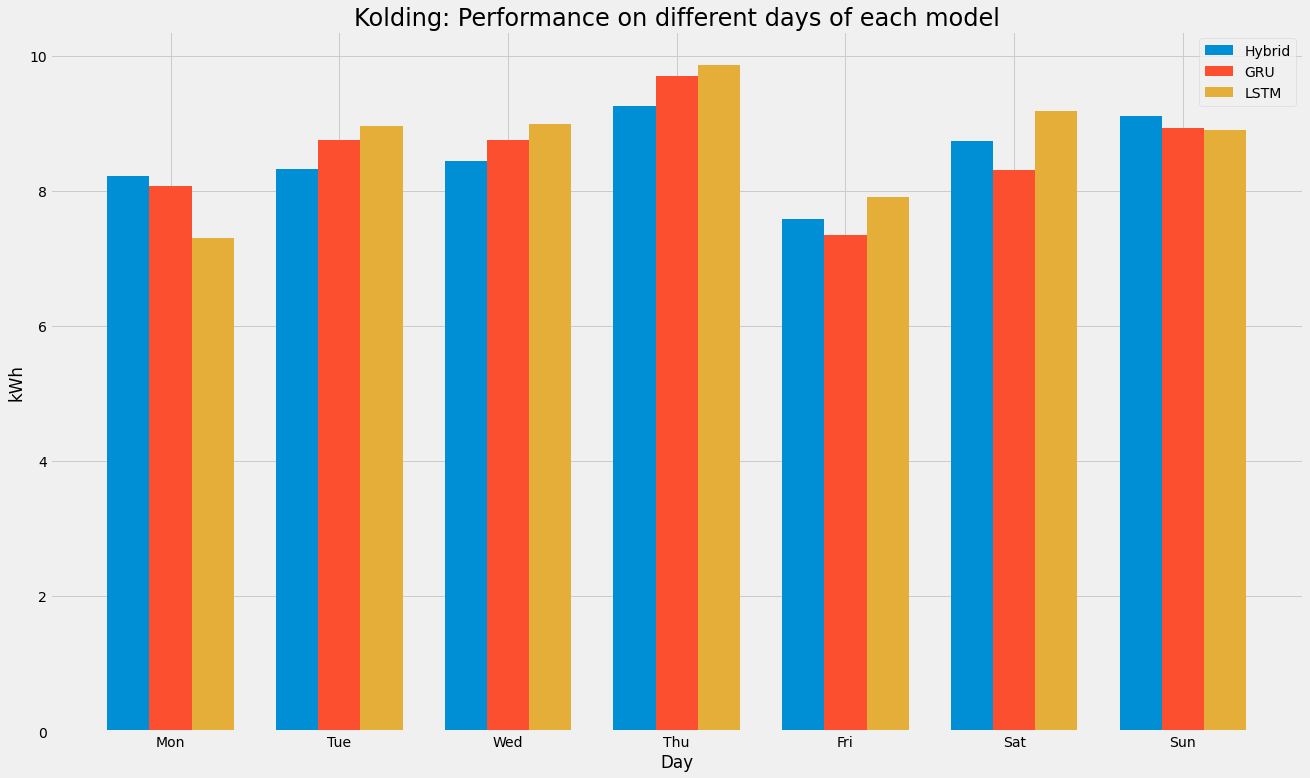

In [87]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
width = 0.25

kld_hyb_day_mae = [8.22, 8.32, 8.45, 9.26, 7.58, 8.74, 9.11]
kld_gru_day_mae = [8.07, 8.75, 8.76, 9.7, 7.35, 8.31, 8.94]
kld_lstm_day_mae = [7.31, 8.97, 8.99, 9.87, 7.91, 9.19, 8.9]
 

r1 = np.arange(len(kld_hyb_day_mae))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
 

plt.bar(r1, kld_hyb_day_mae, width=width, label='Hybrid')
plt.bar(r2, kld_gru_day_mae, width=width, label='GRU')
plt.bar(r3, kld_lstm_day_mae, width=width, label='LSTM')
 
plt.xlabel('Day')
plt.xticks([r + width for r in range(len(kld_hyb_day_mae))], labels)
plt.ylabel('kWh')

plt.title('Kolding: Performance on different days of each model', fontsize=24)
plt.legend()


plt.savefig('/content/drive/MyDrive/Thesis/day_maes_perf_kolding.png', bbox_inches='tight')
plt.show()

# GRU Middelfart

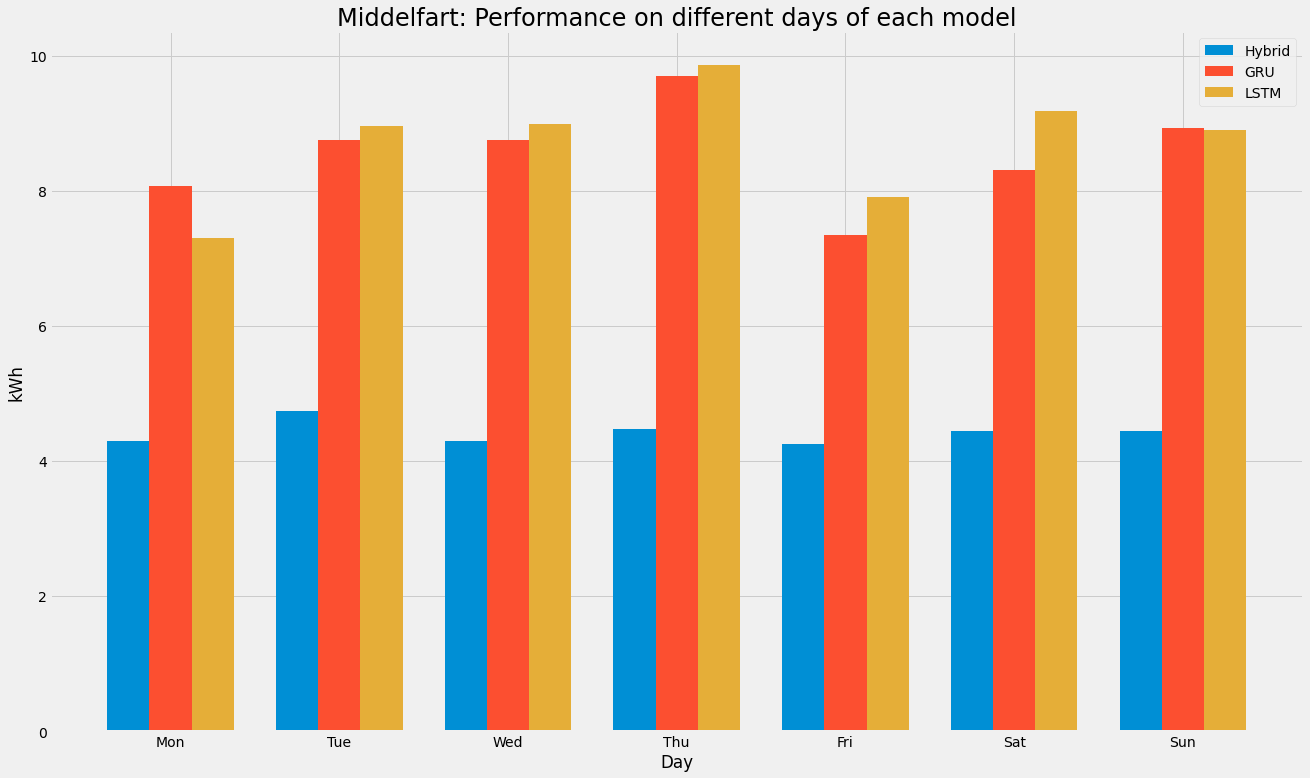

In [89]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
width = 0.25

stb_hyb_day_mae = [4.3, 4.74, 4.3, 4.48, 4.26, 4.44, 4.45]
stb_gru_day_mae = [8.07, 8.75, 8.76, 9.7, 7.35, 8.31, 8.94]
stb_lstm_day_mae = [7.31, 8.97, 8.99, 9.87, 7.91, 9.19, 8.9]
 

r1 = np.arange(len(stb_hyb_day_mae))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
 

plt.bar(r1, stb_hyb_day_mae, width=width, label='Hybrid')
plt.bar(r2, stb_gru_day_mae, width=width, label='GRU')
plt.bar(r3, stb_lstm_day_mae, width=width, label='LSTM')
 
plt.xlabel('Day')
plt.xticks([r + width for r in range(len(stb_hyb_day_mae))], labels)
plt.ylabel('kWh')

plt.title('Middelfart: Performance on different days of each model', fontsize=24)
plt.legend()


plt.savefig('/content/drive/MyDrive/Thesis/day_maes_perf_middelfart.png', bbox_inches='tight')
plt.show()

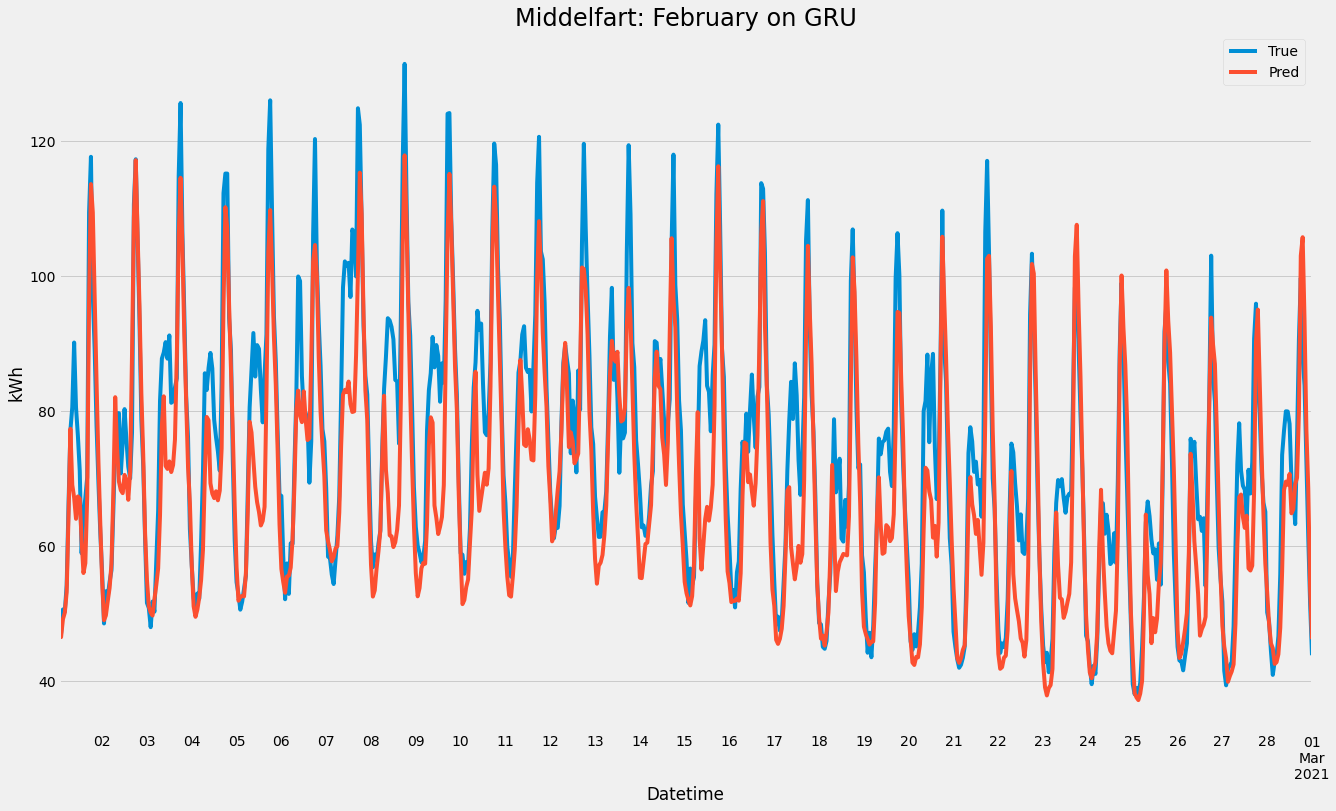

In [109]:
ax = stb_gru_pred.loc[dt.date(2021, 2, 1):dt.date(2021, 3, 1)].plot()
ax.set_title('Middelfart: February on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_february_strib.png', bbox_inches='tight')
plt.show()

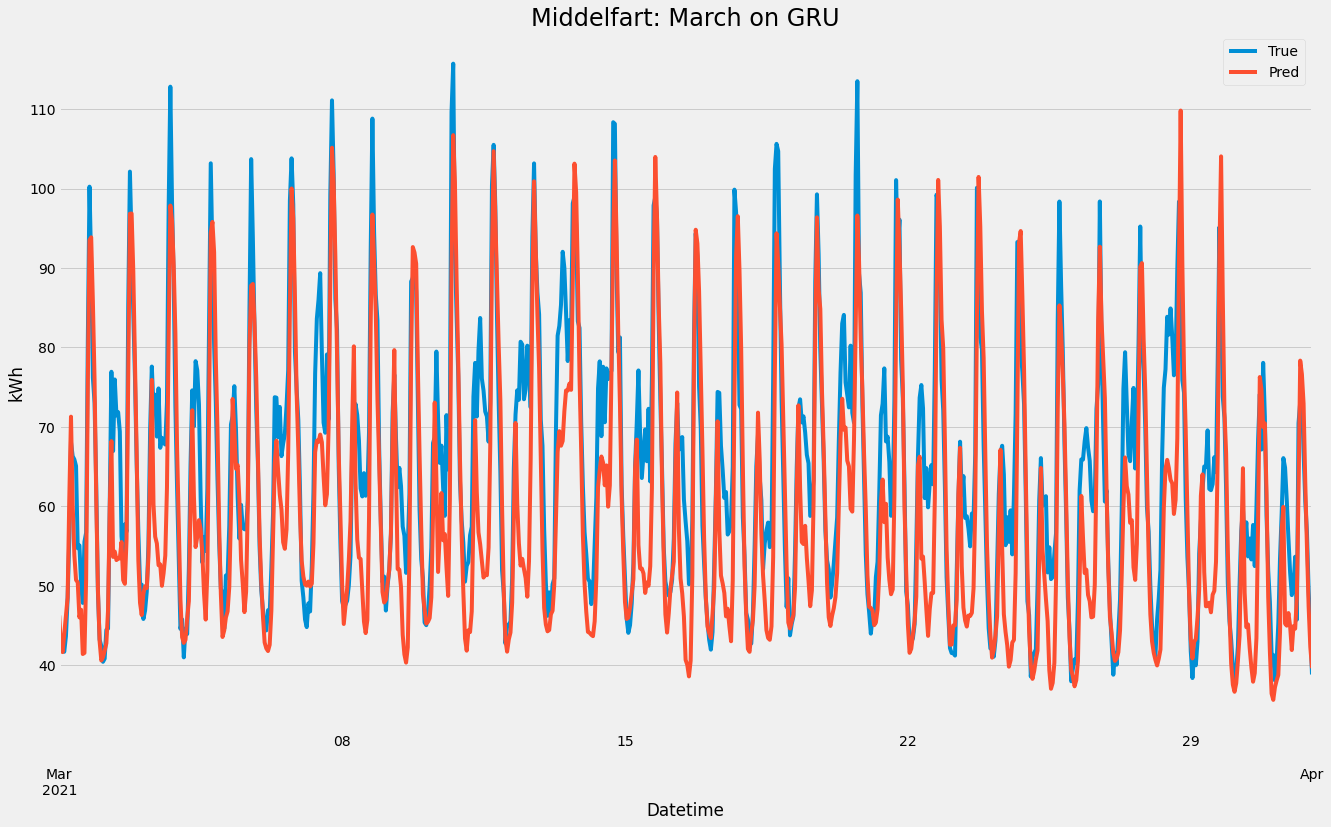

In [106]:
ax = stb_gru_pred.loc[dt.date(2021, 3, 1):dt.date(2021, 4, 1)].plot()
ax.set_title('Middelfart: March on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_march_strib.png', bbox_inches='tight')
plt.show()

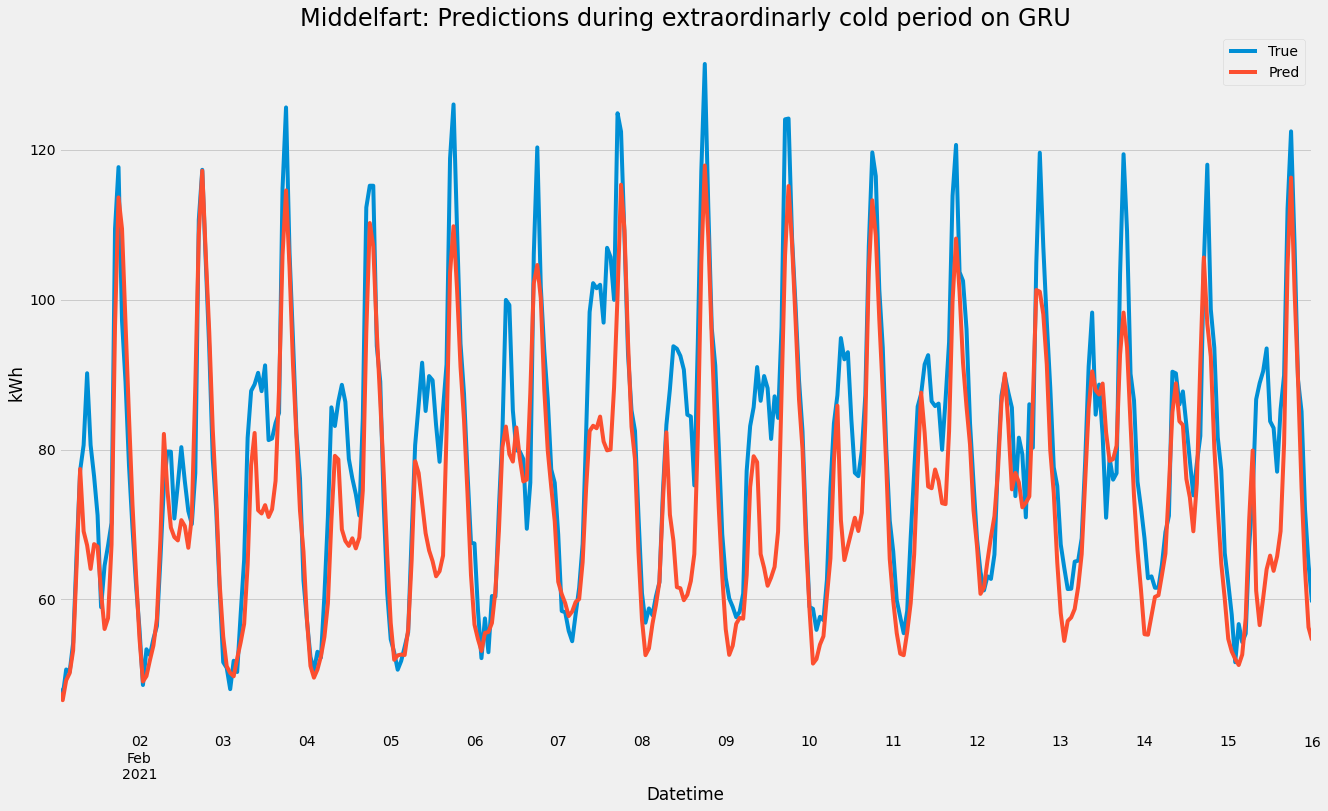

In [95]:
ax = stb_gru_pred.loc[dt.date(2021, 2, 1):dt.date(2021, 2, 16)].plot()
ax.set_title('Middelfart: Predictions during extraordinarly cold period on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_cold_period_strib.png', bbox_inches='tight')
plt.show()

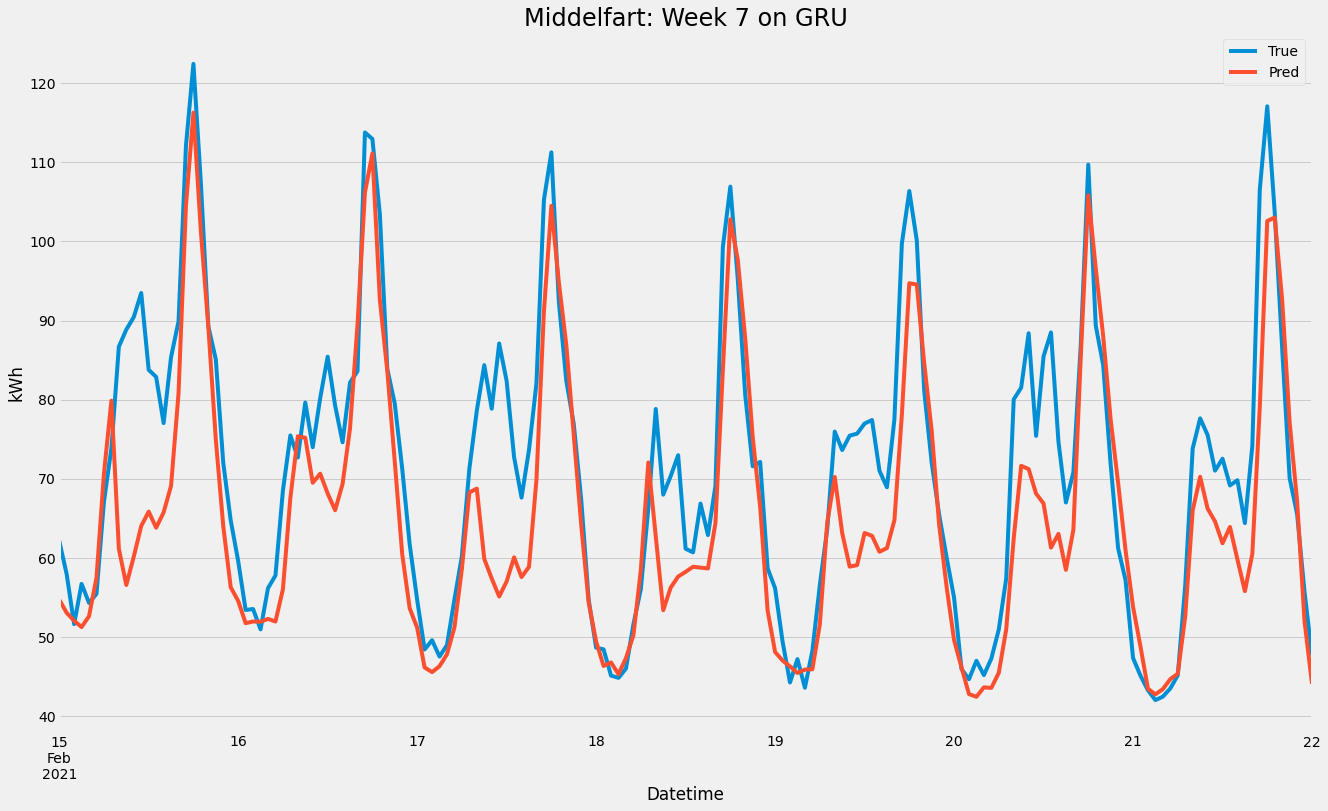

In [96]:
ax = stb_gru_pred.loc[dt.date(2021, 2, 15):dt.date(2021, 2, 22)].plot()
ax.set_title('Middelfart: Week 7 on GRU', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_week7_stb.png', bbox_inches='tight')
plt.show()

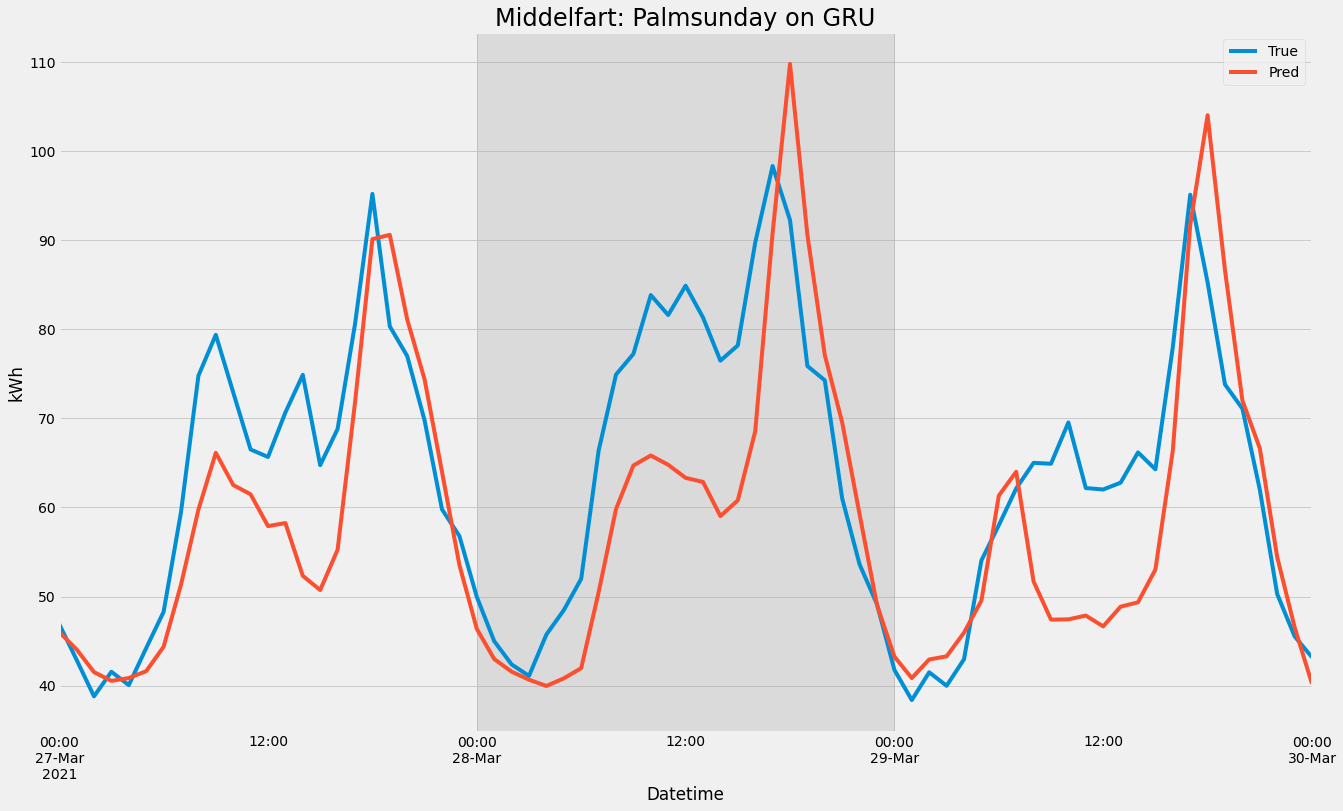

In [97]:
ax = stb_gru_pred.loc[dt.date(2021, 3, 27):dt.date(2021, 3, 30)].plot()
ax.set_title('Middelfart: Palmsunday on GRU', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 3, 28), dt.date(2021, 3, 29), color='darkgrey', alpha=.3)
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_palmsunday_strib.png', bbox_inches='tight')
plt.show()

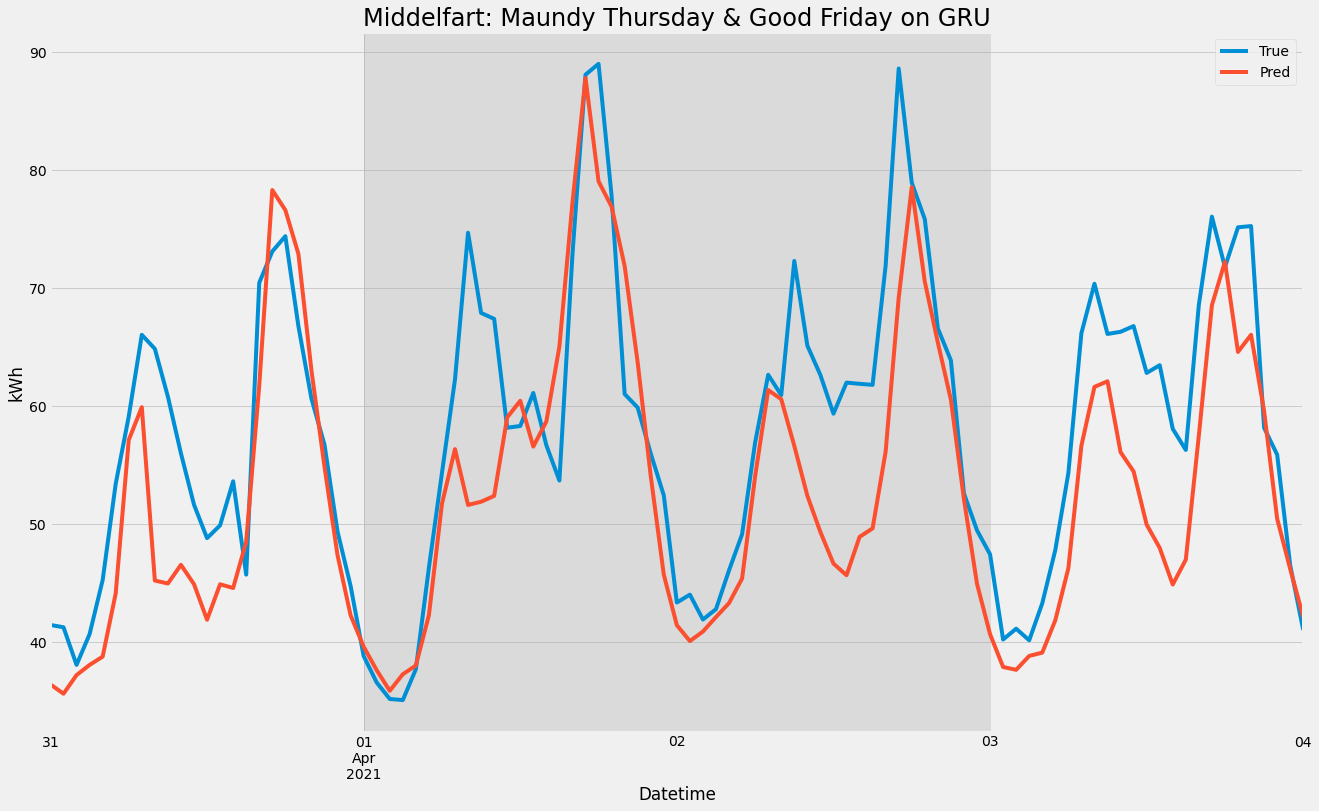

In [98]:
ax = stb_gru_pred.loc[dt.date(2021, 3, 31):dt.date(2021, 4, 4)].plot()
ax.set_title('Middelfart: Maundy Thursday & Good Friday on GRU', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 4, 1), dt.date(2021, 4, 3), color='darkgrey', alpha=.3)
plt.savefig('/content/drive/MyDrive/Thesis/gru_pred_goodfriday_strib.png', bbox_inches='tight')
plt.show()